# Exploring Security Practices in Infrastructure as Code: An Empirical Study of Google Terraform Configurations

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.dpi'] = 300

In [50]:
RESULTS_FILE = "./csv/google_results-tfsec.csv"
POLICIES_FILE = "./csv/google_policies_tfsec.csv"
DATASET = "./csv/google_dataset_filtered.csv"
METRICS_FILE = "./csv/google_dataset_metrics.csv"

Retrieve the list of the 121 selected policies and their mapped categories.
We also print the policies list to use in the checkov_looper.py Python script.

In [51]:
categories = {}
policies = {}
p_names = {}
with open(POLICIES_FILE, 'r') as f:
    f.readline()
    policies_rows = f.readlines()
    for row in policies_rows:
        s_row = row.split(',')
        if s_row[4] == "TRUE":
            policy_id = s_row[6]
            policy_name = s_row[2]
            policy_description = s_row[3]
            policy_category = s_row[5].strip('\n')
            if policy_category == "":
                policy_category = "Uncategorized"

            policies[policy_id] = policy_description
            categories[policy_id] = policy_category
            p_names[policy_id] = policy_name

In [52]:
print("CHECK_LIST = " + ",".join(policies))

CHECK_LIST = AVD-GCP-0004,AVD-GCP-0008,AVD-GCP-0009,AVD-GCP-0007,AVD-GCP-0006,AVD-GCP-0011,AVD-GCP-0003,AVD-GCP-0046,AVD-GCP-0002,AVD-AZU-0007,AVD-GCP-0049,AVD-GCP-0056,AVD-GCP-0059,AVD-GCP-0060,AVD-GCP-0052,AVD-GCP-0053,AVD-GCP-0062,AVD-GCP-0050,AVD-GCP-0013,AVD-GCP-0012,AVD-GCP-0014,AVD-GCP-0015,AVD-GCP-0023,AVD-GCP-0019,AVD-GCP-0017,AVD-GCP-0025,AVD-GCP-0016,AVD-GCP-0022,AVD-GCP-0018,AVD-GCP-0020,AVD-GCP-0021,AVD-GCP-003,AVD-GCP-0037,AVD-GCP-0045,AVD-GCP-0029,AVD-GCP-0044,AVD-GCP-0043,AVD-GCP-0036,AVD-GCP-0030,AVD-GCP-0035,AVD-GCP-0027,AVD-GCP-0031,AVD-GCP-0032,AVD-GCP-0039,AVD-GCP-0033,


## RQ1: Category Mapping Distribution

In [53]:
categories_count = {}
for policy in policies:
    categories_count[categories.get(policy, "Uncategorized")] = categories_count.get(categories.get(policy, "Uncategorized"), 0) + 1

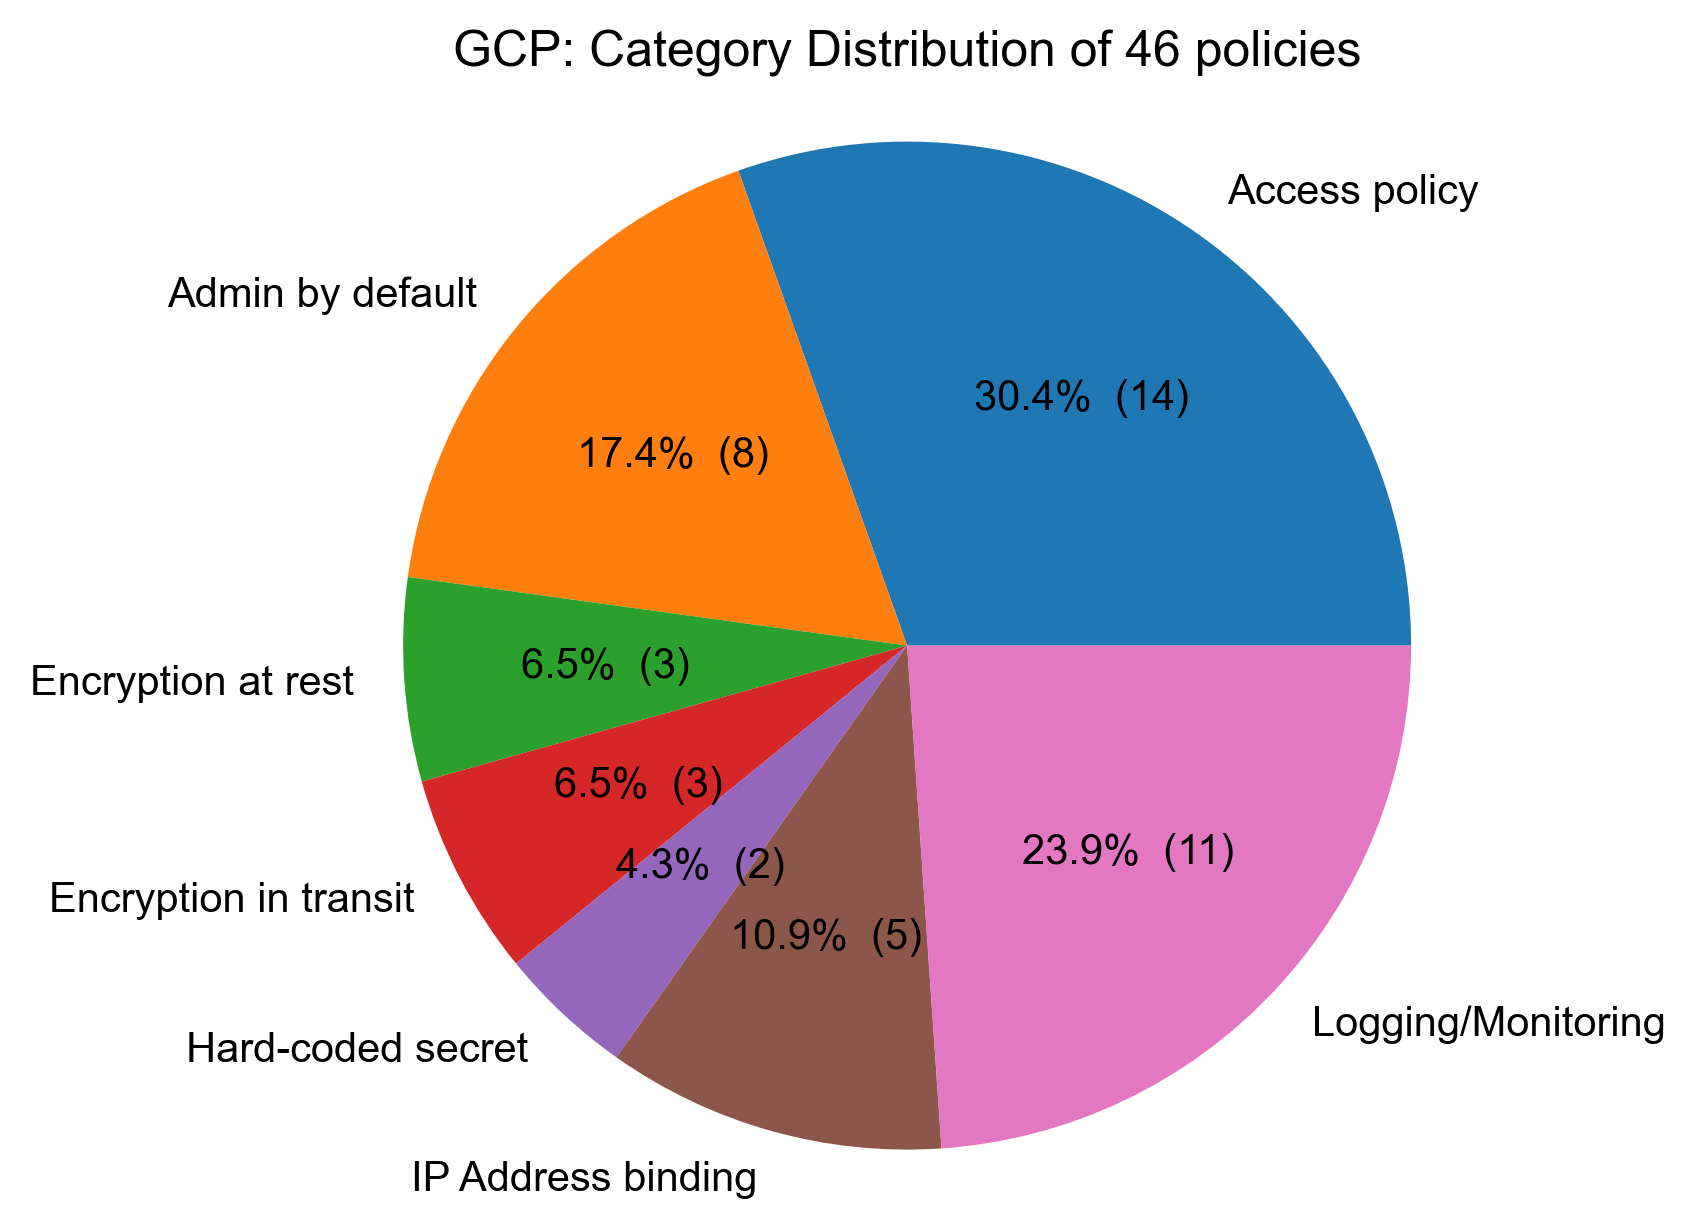

In [54]:
labels2 = sorted([*categories_count.keys()])
sizes2 = [categories_count[k] for k in labels2]
fig2, ax2 = plt.subplots()
ax2.pie(sizes2, labels=labels2, autopct=lambda p : '{:.1f}%  ({:,.0f})'.format(p,p * sum(sizes2)/100))
ax2.axis('equal')
ax2.set(title="GCP: Category Distribution of {} policies".format(len(policies)))
plt.show()

## Results analysis

Load the repository list of our dataset and the checkov results

In [55]:
with open(DATASET, 'r') as f:
    f.readline()
    tmp_repo_names = f.readlines()
repo_names = [k.strip("\n") for k in tmp_repo_names]

In [56]:
with open(RESULTS_FILE, 'r') as f:
    f.readline()
    repo_results = f.readlines()

Aggregate the results per category. Ensures all policies in the results are categorized (have been selected and mapped to a category).

In [57]:
passed_count_dict = {}
failed_count_dict = {}
categories_passed_counts = {}
categories_failed_counts = {}
uncategorized_policies = {}
repo_results_list = []
for row in repo_results:
    columns = row.split(',')
    repo_name = columns[0]
    if repo_name in repo_names:
        passed_policies = columns[3].split(';')
        failed_policies = columns[4].split(';')
        repo_results_list.append([len(passed_policies), len(failed_policies)])

        for policy in passed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_passed_counts[categories.get(policy, "Uncategorized")] = categories_passed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                passed_count_dict[policy] = passed_count_dict.get(policy, 0) + 1
                
        for policy in failed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_failed_counts[categories.get(policy, "Uncategorized")] = categories_failed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                failed_count_dict[policy] = failed_count_dict.get(policy, 0) + 1
                

total_count = {}
for policy in passed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + passed_count_dict[policy]
for policy in failed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + failed_count_dict[policy]
                    
print("Uncategorized policies: {}".format([*uncategorized_policies.keys()]))
print("Total number of passed policies: {}".format(sum(passed_count_dict.values())))
print("Total number of failed policies: {}".format(sum(failed_count_dict.values())))
print("Median number of checks per policy: {}".format(np.median([*total_count.values()])))
print("Average number of checks per policy: {}".format(np.average([*total_count.values()])))
print("STD of checks per policy: {}".format(np.std([*total_count.values()])))
print("Skewness of checks per policy: {}".format(sp.skew([*total_count.values()])))
print("Skewness of checks per policy: {}".format((np.average([*total_count.values()])-np.median([*total_count.values()]))/np.std([*total_count.values()])))

Uncategorized policies: ['AVD-GCP-0041', 'AVD-GCP-0066', 'AVD-GCP-0001', 'AVD-GCP-0024', 'AVD-GCP-0026', 'AVD-AWS-0164', 'AVD-AWS-0029', 'AVD-AWS-0057', 'AVD-AWS-0017', 'AVD-AWS-0099', 'AVD-AWS-0124', 'AVD-AWS-0131', 'AVD-AWS-0028', 'AVD-AWS-0104', 'AVD-AWS-0107', 'AVD-AWS-0178', 'AVD-GCP-0064', 'AVD-GCP-0057', 'AVD-GCP-0054', 'AVD-GCP-0055', 'AVD-GCP-0063', 'AVD-GCP-0058', 'AVD-GCP-0061', 'AVD-GCP-0047', 'AVD-GCP-0048', 'AVD-GCP-0051', 'AVD-GCP-0065', 'AVD-GCP-0042', 'AVD-GCP-0034', 'AVD-AWS-0067', 'AVD-AWS-0066', 'AVD-AWS-0012', 'AVD-AWS-0030', 'AVD-AWS-0092', 'AVD-AWS-0010', 'AVD-AWS-0011', 'AVD-AWS-0013', 'AVD-AWS-0031', 'AVD-AWS-0033', 'AVD-AWS-0086', 'AVD-AWS-0087', 'AVD-AWS-0088', 'AVD-AWS-0089', 'AVD-AWS-0090', 'AVD-AWS-0132', 'AVD-AWS-0091', 'AVD-AWS-0093', 'AVD-AWS-0094', 'AVD-AWS-0038', 'AVD-AWS-0039', 'AVD-AWS-0040', 'AVD-AWS-0041', 'AVD-AZU-0016', 'AVD-AZU-0015', 'AVD-AZU-0017', 'AVD-AZU-0013', 'AVD-AWS-0065', 'AVD-AZU-0014', 'AVD-AZU-0039', 'AVD-AZU-0038', 'AVD-AZU-0037',

In [58]:
nb_of_checks = []
for i in repo_results_list:
    nb_of_checks.append(i[0]+i[1])
rate_list = []
for i in repo_results_list:
    rate_list.append(100*i[0]/(i[0]+i[1]))
    
print("Median number of checks per repo: {}".format(np.median(nb_of_checks)))
print("Average number of checks per repo: {}".format(np.average(nb_of_checks)))
print("STD of checks per repo: {}".format(np.std(nb_of_checks)))
print("Skewness of checks per repo: {}".format((np.average(nb_of_checks)-np.median(nb_of_checks))/np.std(nb_of_checks)))
print("\n")
print("Median pass rate per repo: {}".format(np.median(rate_list)))
print("Average pass rate per repo: {}".format(np.average(rate_list)))

Median number of checks per repo: 21.0
Average number of checks per repo: 88.22314049586777
STD of checks per repo: 241.7824986524047
Skewness of checks per repo: 0.27803145748985825


Median pass rate per repo: 52.086956521739125
Average pass rate per repo: 59.10948000940747


### Generate the Paper Full Table with the results

In [59]:
inv_cat = {}
for k, v in categories.items():
    inv_cat[v] = inv_cat.get(v, []) + [k]
tp = ""
for cat in inv_cat:
    p = inv_cat[cat]
    tp = tp + "\multirow{" + str(len(p)) + "}{*}{" + cat + "}"
    for i in p:
        if total_count.get(i,0) != 0:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " + str(passed_count_dict.get(i,0)/total_count.get(i,0)*100)[:5] +"\\\\ \n"
        else:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " +"\\\\ \n"
    tp = tp + "\hline \n"
tp = tp.replace("_", "\_")
print(tp)

\multirow{8}{*}{Admin by default} & Roles should not be assigned to default service accounts & 24 & 24 & 0 & 100.0\\ 
 & Roles should not be assigned to default service accounts & 83 & 83 & 0 & 100.0\\ 
 & Users should not be granted service account access at the organization level & 83 & 80 & 3 & 96.38\\ 
 & Service accounts should not have roles assigned with excessive privileges & 460 & 272 & 188 & 59.13\\ 
 & Roles should not be assigned to default service accounts & 1912 & 1889 & 23 & 98.79\\ 
 & Users should not be granted service account access at the project level & 1858 & 1771 & 87 & 95.31\\ 
 & Cross-database ownership chaining should be disabled & 21 & 0 & 21 & 0.0\\ 
 & Instances should not use the default service account & 184 & 170 & 14 & 92.39\\ 
\hline 
\multirow{14}{*}{Access policy} & IAM granted directly to user. & 2019 & 2004 & 15 & 99.25\\ 
 & BigQuery datasets should only be accessible within the organisation & 15 & 15 & 0 & 100.0\\ 
 & Ensure that Cloud Storage b

## RQ2/RQ3 : Category Pass/Fail Rate

In [60]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 0:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

categories_rates = {}
for category in [*categories.values()]:
    categories_rates[category] = categories_passed_counts[category] / (categories_passed_counts[category] + categories_failed_counts.get(category, 0))

#categories_rates = {}
#for policy in policies_rate:
 #   categories_rates[categories[policy]] = categories_rates.get(categories[policy], []) + [policies_rate[policy]]
#for category in categories_rates:
 #   categories_rates[category] = np.average(categories_rates.get(category, []))
print(categories_rates)
print(categories_failed_counts)

{'Admin by default': 0.9273513513513514, 'Access policy': 0.7829112162538269, 'IP Address binding': 0.6014760147601476, 'Logging/Monitoring': 0.3705636743215031, 'Encryption in transit': 0.25157232704402516, 'Encryption at rest': 0.22968197879858657, 'Hard-coded secret': 0.9963369963369964}
{'Logging/Monitoring': 603, 'Access policy': 780, 'IP Address binding': 324, 'Encryption at rest': 218, 'Admin by default': 336, 'Encryption in transit': 119, 'Hard-coded secret': 1}


In [68]:
import pickle
categories_rates['Outdated feature'] = 0.0
with open('./google_categories_rates_tfsec.pkl', 'wb') as f:
    pickle.dump(categories_rates, f)

print(categories_rates)

{'Admin by default': 0.9273513513513514, 'Access policy': 0.7829112162538269, 'IP Address binding': 0.6014760147601476, 'Logging/Monitoring': 0.3705636743215031, 'Encryption in transit': 0.25157232704402516, 'Encryption at rest': 0.22968197879858657, 'Hard-coded secret': 0.9963369963369964, 'Outdated feature': 0.0}


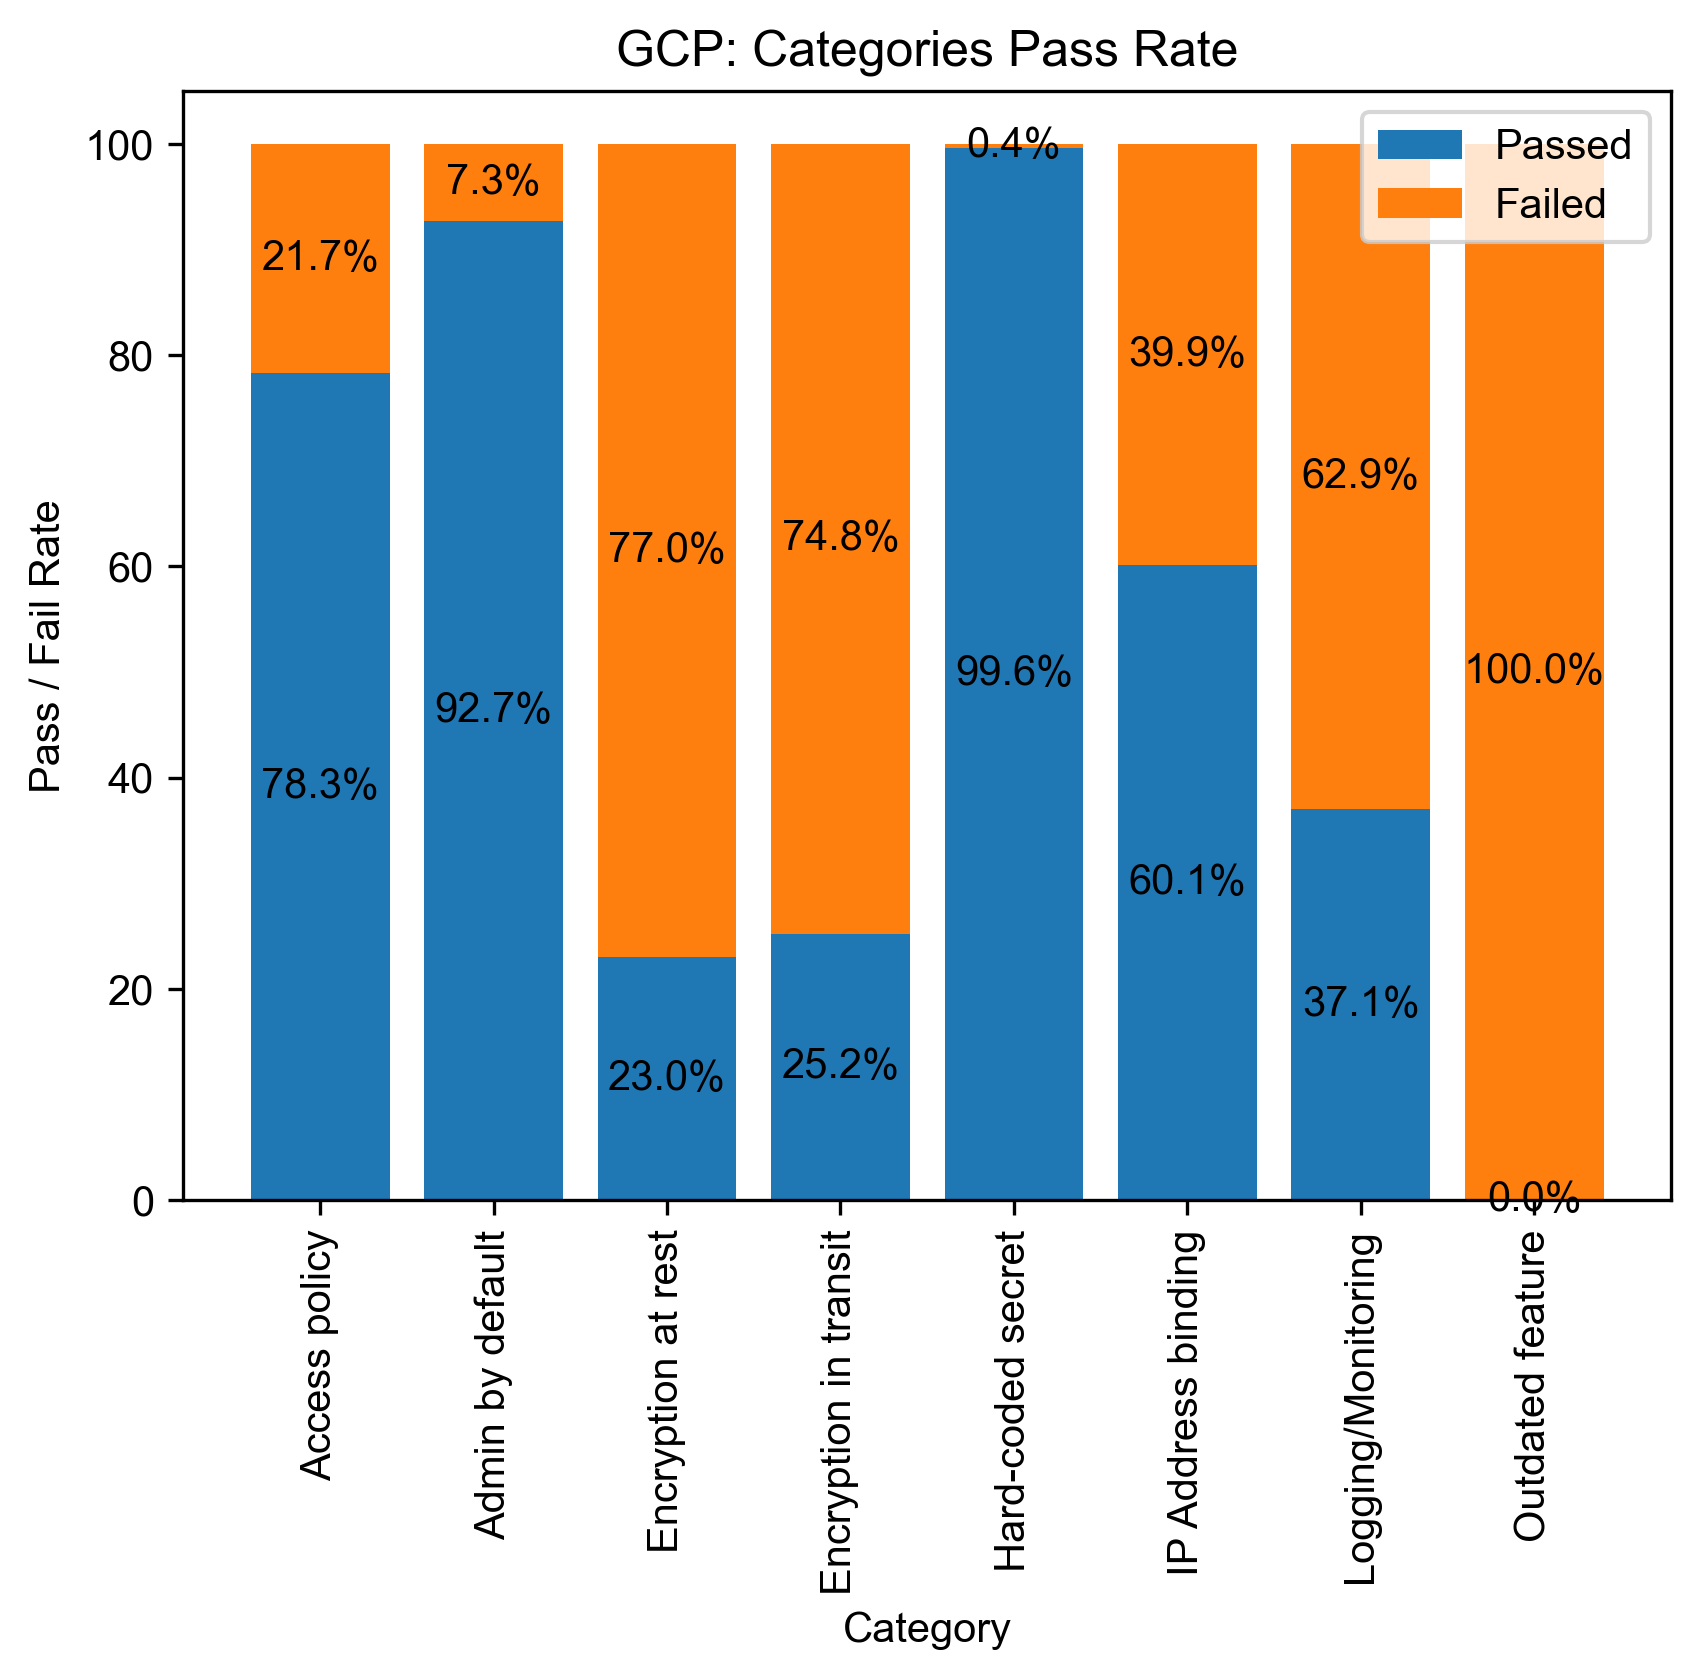

In [63]:
fig7, ax7 = plt.subplots()
x = sorted([*categories_rates.keys()])
y1 = [100*categories_rates[k] for k in x]
y2 = [100-k for k in y1]
bc1 = ax7.bar(x, y1)
bc2 = ax7.bar(x, y2, bottom=y1)
ax7.bar_label(bc1, labels=['{0:.1f}%'.format(e) for e in y1], label_type='center')
ax7.bar_label(bc2, labels=['{0:.1f}%'.format(e) for e in y2], label_type='center')
ax7.set(xlabel="Category", ylabel="Pass / Fail Rate", title="GCP: Categories Pass Rate")
ax7.legend(["Passed", "Failed"])
plt.xticks(rotation=90)
plt.show()

## RQ2/RQ3 : Best and Worst Pass/Fail Policies

In [64]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 50:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

print("Averate Pass/Fail Rate: {}".format(np.average([*policies_rate.values()])))
        
sorted_policies_rates = sorted(policies_rate, key=policies_rate.get, reverse=True)
print("Best 5 Pass / Fail Rate Policies")
for policy in sorted_policies_rates[:6]:
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))
print("Worst 5 Pass / Fail Rate Policies")
for policy in reversed(sorted_policies_rates[-7:]):
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))

Averate Pass/Fail Rate: 0.5965929776377632
Best 5 Pass / Fail Rate Policies
AVD-GCP-0008 - 83 - 1.0
AVD-GCP-0012 - 63 - 1.0
AVD-GCP-0018 - 56 - 1.0
AVD-GCP-0021 - 56 - 1.0
AVD-GCP-0037 - 273 - 0.9963369963369964
AVD-GCP-0003 - 2019 - 0.9925705794947994
Worst 5 Pass / Fail Rate Policies
AVD-GCP-0030 - 184 - 0.0
AVD-GCP-0033 - 220 - 0.00909090909090909
AVD-GCP-0017 - 149 - 0.020134228187919462
AVD-GCP-0045 - 184 - 0.05434782608695652
AVD-GCP-0029 - 202 - 0.07920792079207921
AVD-GCP-0020 - 56 - 0.14285714285714285
AVD-GCP-0022 - 56 - 0.14285714285714285


Print Average number of test per category

In [65]:
policies_nb_runs = {}
for policy in policies:
    policies_nb_runs[policy] = passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)

mean_category_runs = {}
for policy in policies_nb_runs:
    mean_category_runs[categories.get(policy, "Uncategorized")] = mean_category_runs.get(categories.get(policy, "Uncategorized"), []) + [policies_nb_runs[policy]]

for category in mean_category_runs:
    print(str(category) +" "+ str(np.sum(mean_category_runs[category])))
    mean_category_runs[category] = np.average(mean_category_runs[category])
print(mean_category_runs)

Admin by default 4625
Access policy 3593
IP Address binding 813
Logging/Monitoring 958
Encryption in transit 159
Encryption at rest 283
Hard-coded secret 273
{'Admin by default': 578.125, 'Access policy': 256.64285714285717, 'IP Address binding': 162.6, 'Logging/Monitoring': 87.0909090909091, 'Encryption in transit': 53.0, 'Encryption at rest': 94.33333333333333, 'Hard-coded secret': 136.5}


In [66]:
stars = []
forks = []
contrib = []
with open(METRICS_FILE, 'r') as f:
    #f.readline()
    rows = f.readlines()
    for item in rows:
        column = item.split(',')
        if column[0] in repo_names:
            stars.append(int(column[1]))
            forks.append(int(column[2]))
            contrib.append(int(column[3].strip("\n")))

In [67]:
print("Average stars: {}".format(np.average(stars)))
print("Median stars: {}".format(np.median(stars)))
print("Average forks: {}".format(np.average(forks)))
print("Median forks: {}".format(np.median(forks)))
print("Average conrtib: {}".format(np.average(contrib)))
print("Median contrib: {}".format(np.median(contrib)))

Average stars: 281.31021897810217
Median stars: 9.5
Average forks: 95.36861313868613
Median forks: 5.0
Average conrtib: 9.89051094890511
Median contrib: 4.0
